In [1]:
"""
Today we will be looking at some more neural network examples, specifically with other optimizers and architectures
for MNIST, the different training options, and lastly the map reduce algorithm. Let's get started!
"""

import sealion as sl 
from sealion import neural_networks as nn

In [2]:
# first let's get MNIST data
from sealion.utils import one_hot
from tensorflow.keras.datasets import mnist # we'll use this in the interest of time
(X_train, y_train), (X_test, y_test) = mnist.load_data() # unpack it

X_train = X_train / 255.0 # divide by 255 for faster convergence (normalization, if you care about that)
X_test = X_test / 255.0

# one hot our labels (to make them work with the softmax)
y_train = one_hot(y_train, depth = 10) # 10 classes
y_test = one_hot(y_test, depth = 10)

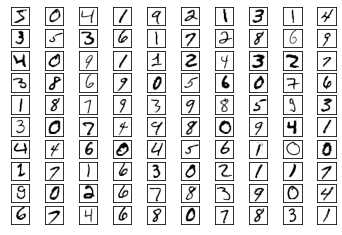

In [3]:
# we can actually visualize some of the images (thank you Data Science From Scratch for this method): 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(10, 10)

for i in range(10) : 
    for j in range(10) : 
        ax[i][j].imshow(X_train[10 * i + j], cmap = "Greys")
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
plt.show()

In [4]:
# we can now start building our neural network
model = nn.models.NeuralNetwork()
model.add(nn.layers.Flatten()) # flatten the 2D input
model.add(nn.layers.Dense(784,72, activation = nn.layers.ELU(alpha = 1)))
model.add(nn.layers.Dropout(0.2))
model.add(nn.layers.Dense(72, 36, activation = nn.layers.Tanh()))
model.add(nn.layers.Dropout(0.2))
model.add(nn.layers.Dense(36, 10, activation = nn.layers.Softmax()))

In [5]:
# not your typical architecture, so let's explain what's going on. 
# firstly we have some dropout layers, that will dropout roughly 20% of the neurons (they will be set to 0)
# which will help prevent overfitting

# we also have used an ELU and Tanh layer. If you are unfamiliar with the ELU just know that its like a ReLU except 
# with an asymptote on the negative x-axis to alpha (default 1). Tanh squeezes all values from -1 to 1 (just think of a steeper sigmoid)

In [6]:
# we can now setup our optimizer
model.finalize(loss = nn.loss.CrossEntropy(), optimizer = nn.optimizers.RMSProp(lr = 0.01)) # not much of a choice on the loss func

# RMSProp optimization is just a way of taking into account the past gradients unlike traditional gradient descent. 

# and we train. 

model.train(X_train, y_train, epochs = 10)

Acc : 96.48%: 100%|█████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.94s/it]


In [7]:
# the model does suprisingly well . 

# however there's a little more to be said. The comments below do have some unavoidable jargon, which I try to keep to minima (get it?)
# the first thing is that the way the .train() method works is that you have a default batch_size = 32 parameter
# whatever the batch_size is will determine the number of batches there will be.
# then what we do is for every epoch forward and backprop all of the datasets using all available CPU cores. 

# in general larger batch sizes do better in practice, because then the forward and backprop goes slightly quicker. 
# however larger batch sizes mean smaller datasets for gradients to be calculated off of, so that's also another thing

model.train(X_train, y_train, epochs = 10, batch_size = 300)

Acc : 96.0%: 100%|██████████████████████████████████████████████████| 10/10 [00:46<00:00,  4.68s/it]


In [8]:
# it didn't make much of a difference here, either. 

# however, we can also just use less data to calculate gradients off of
# that's known as mini-batch gradient descent, where you randomly take N % of the data at each iteration 
# to calculate the gradients. We do have something just for that. 

model.mini_batch_train(X_train, y_train, epochs = 10, N = 0.1) # we'll only use 6000 digits (10% of the data) to # calculate gradients on

Acc : 97.26%: 100%|█████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.09s/it]


In [9]:
# now if for whatever reason you want to just keep it simple and calculate gradients on the whole dataset
# you sure can 
model.full_batch_train(X_train[:10000], y_train[:10000], epochs = 15) # we'll just use 10k images (very slow)

Acc : 98.31%: 100%|█████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.36s/it]


In [10]:
# looks like we can move onto the map reduce algorithm. 
# once you understand mini-batch training and batch_size, map reduce is simple
# let's say you want to train your model FAST and you have just 4 cores on your machine
# what you can do is split the data into 4 chunks, and train a separate model on each core in parallel 
# then at test time you can have each model predict on your prediction data and just average it out. 
# it's sort of like ensemble learning for neural networks


# what I just described is essentially the map reduce algorithm. 
# in code : 

model = nn.models.NeuralNetwork_MapReduce() # we'll use a slightly different architecture this time
model.add(nn.layers.Flatten())
model.add(nn.layers.Dense(784, 64, activation = nn.layers.Swish())) # a little more hip activation function
model.add(nn.layers.Dense(64, 32, activation = nn.layers.Swish()))
model.add(nn.layers.Dense(32, 10, activation = nn.layers.Softmax()))

model.finalize(loss = nn.loss.CrossEntropy(), optimizer = nn.optimizers.SGD(lr = 0.2, momentum = 0.3, nesterov = True))               

In [11]:
# then we can just train this  
model.train(X_train, y_train, epochs = 15, batch_size = 32, num_cores = -1) # this batch size param gets applied to all of the models

# by default num_cores = -1, which just means use all cores. 
# using num_cores = -2, would just mean save 1 core than I have, and num_cores = -3 would mean save 2 cores
# using num_cores = 2, num_cores = 3 just means use 2 or 3 cores respectively. 

In [12]:
# no progress bar for model.train() given the difficulty of communicating and aggregating progress on multiple cores

# and we can now make some predictions
y_pred = model.predict(X_test)

# we need to get this out of one-hot-encoding
from sealion.utils import revert_one_hot
import numpy as np
y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
y_test= np.apply_along_axis(np.argmax, 1, y_test)

# we can do this : 
print(y_pred == y_test)

# and we can evaluate : 
model.categorical_evaluate(X_test, one_hot(y_test, depth = 10)) # needs to be one_hotted y_test

[ True  True  True ...  True  True  True]


0.844

In [13]:
# pretty good considering the model we used. Well that's all for now. Thank you!